# P411 - Assignment 4
Kristi Webb, Oct 8 2015

github k-a-webb

In [101]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from matplotlib import mlab

## Q1:Discrete FFT and Power Spectrum

**1** Using the data from the hourly time series at Deep Cove (`dc`), show that the canned `fft` routine returns the correct discrete Fourier Transform of a suitable subset of the data (your choice on what subset).  You can do this graphically, by comparing the amplitude and the phase of the Fourier components, or simply show that the resulting numbers are the same.  

Some Hints: 
  - ignore bad data (rather than dealing with it "properly").  Make sure the units of your FT are: $\mathrm{^oC\, s}$.
  - If you want to compute the DFT efficiently, form the matrix $F$ referred to in the notes, and plot some of the time series associated with the different entries and make sure they look like Sines and Cosines and that the edge conditions are what you want.  Alternately, you can use your dft routine from the last assignment, and chose your frequencies properly.

<hr>

In [252]:
hourdata=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/AllHourly.txt')[[6,28],2:]
dc = hourdata[0,:]
jb = hourdata[1,:]
dcc = dc[np.isfinite(dc+jb)]
jb = jb[np.isfinite(dc+jb)]
dc=dcc

Nt = len(dc)
t = np.arange(Nt) # [hours]
dc -= np.mean(dc)

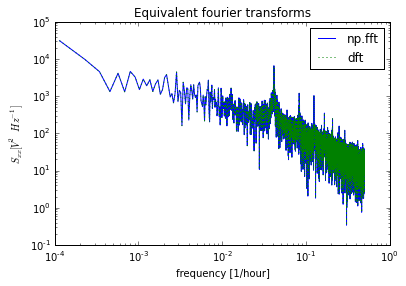

In [253]:
dc_y = dc[:24*365]  # One years data
ts = 1.  # The time step of x[i], x[x+i] is one hour

ft_np = np.abs(np.fft.fft(dc_y))
f = np.fft.fftfreq(dc_y.size, ts)

def dft2(x, ff):
    n = len(x)
    t = np.arange(n)
    ft = x*0.
    for i in np.arange(n):
        ft[i] = np.abs(np.sum(x * np.exp( -2j * np.pi * ff[i] * t)))
    return ft

ft = dft2(dc_y, f)

plt.loglog(f, ft_np, label='np.fft')
plt.loglog(f, ft, ':g', label='dft')
plt.xlabel('frequency [1/hour]') ; plt.ylabel(r'$S_{xx} [V^2\,Hz^{-1}]$') ; plt.title('Equivalent fourier transforms') ; plt.legend()

I've tried to make it clear that the two calculated fourier transforms are equivalent for the same frequency values.

<hr>
**2** Now, we can go ahead and use `np.fft.fft`.  Estimate the power spectrum for the Deep Cove time series (again go ahead and skip over gaps, though some of the bigs ones will screw up your frequencies a bit)

  - Use *all* the data.  
  - Report your results in proper SI units.
  - Indicate on your plot at least a couple of important frequencies

<hr>

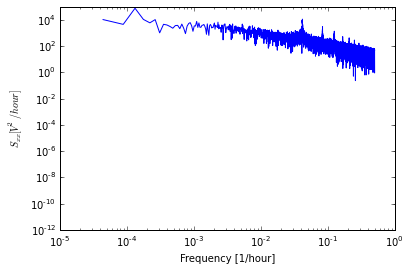

In [256]:
ft = np.abs(np.fft.fft(dc))
f = np.fft.fftfreq(dc.size, ts) # 3600 s in an hour

plt.loglog(f, ft) ; plt.xlabel('Frequency [1/hour]') ; plt.ylabel(r'$S_{xx} [V^2/hour]$')
plt.legend(loc=3)

There are frequency peaks at approximately 24 hours and one year (with slight discrepancies related to haveing Nan values in our data set)

<hr>
**3** Demonstrate Parceval's Theorem applies to your spectral estimate.  i.e. show that 

\begin{equation}
  \sigma_x^2=\int_0^{\infty} G_{xx}(f)\ \mathrm{d}f
\end{equation}

applies to your estimate of $G_{xx}(f)$.
<hr>

In [236]:
def cross_spec(X, f, N):
    NN = int(N)
    stp = f/len(X[:NN/2])
    f = np.arange(0, f, stp)
    return np.real((2./N)*np.conj(X[:NN/2])*X[:NN/2]), f

N = float(len(dc))
g_xx, ff = cross_spec(ft, 0.5, N)

g_xx_var = np.trapz(g_xx, ff)
var = np.var(dc)

print g_xx_var, var

35.8312396115 35.8312448709


The two values are equal which is what we expect

<hr>
## Q2: Emperically derive distribution of spectral estimate
**1** Write a short function to create a "red" time series by taking the cumulative sum of Normally distributed random data, and plot one realization.  The number of data points $N$ can be relatively small (say 1000).
<hr>

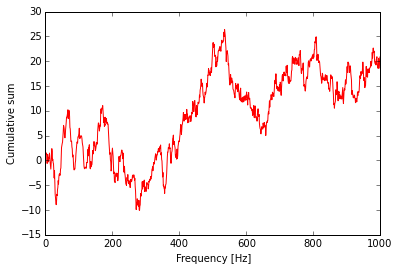

In [234]:
Nt = 1000
def red_time(N):
    return np.cumsum(np.random.randn(N))

x = red_time(Nt)
t = np.arange(len(x))

plt.plot(t, x_sum, '-r') ; plt.xlabel('Frequency [Hz]') ; plt.ylabel('Cumulative sum')

<hr>
**2** Write a second function to return the estimate of the power spectrum of $x$.  For posterity sake, include a value of the sampling frequency, and return the proper frequencies for the estimate.  Plot the resulting spectrum.
<hr>

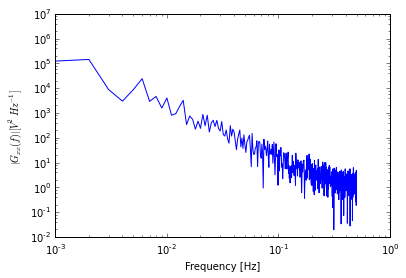

In [249]:
def pow_spec(x, ts=1., plot=False):
    T = len(x)
    
    ft = np.fft.fft(x)
    s_xx = np.conjugate(ft) * ft / T
    g_xx = 2 * np.real(s_xx)
    
    freqs = np.fft.fftfreq(x.size, ts)
    
    if plot:
        plt.loglog(freqs, g_xx) ; plt.xlabel('Frequency [Hz]') ; plt.ylabel(r'$|G_{xx}(f)| [V^2 Hz^{-1}]$')
    
    return g_xx, freqs

g_xx, f = pow_spec(x, 1., plot=True)

<hr>
**3** Now do the Monte-Carlo, by running the above 100 times and plotting the resulting spectral estimates as dots on the same plot. As you are making your data, save it into an array.  I did something like:
```python
    Gxs = zeros((1000,501))
    # inside my loop:
        Gxs[ind,:]=Gxx   
```
<hr>

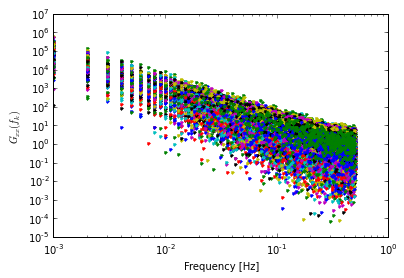

In [250]:
N = 100
f = 0.5

g_xx = np.ndarray((N, Nt))
                
for i in range(N):
    x = red_time(Nt)    
    g, ff = pow_spec(x)
    
    g_xx[i,:] = g
        
    plt.loglog(ff, g, '.')

plt.xlabel('Frequency [Hz]') ; plt.ylabel(r'$G_{xx}(f_k)$')

<hr>
**4** Now, on the same plot, add the mean of all your $G_{xx}(f)$ estimates (as a function of $f$), and the upper and lower bounds encompasing 95% of the data. (Hint, sort each column of your matrix - `np.sort` - and plot the value at $0.025 N$ and $0.975 N$).

<hr>

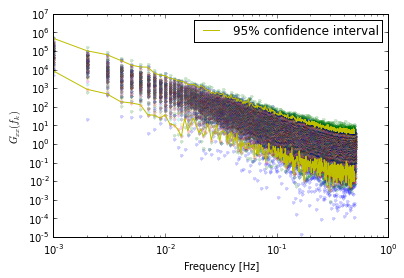

In [246]:
g_xx_s = np.sort(g_xx, axis=0)

il_n = int(0.025*N)
iu_n = int(0.975*N)

g_xx_ln = g_xx_s[il_n]
g_xx_un = g_xx_s[iu_n]

for i in range(N):
    plt.loglog(ff, g_xx_s[i,:], '.', alpha=0.2)

plt.loglog(ff, g_xx_ln, '-y', label='95% confidence interval') ; plt.loglog(ff, g_xx_un, '-y')
plt.xlabel('Frequency [Hz]') ; plt.ylabel(r'$G_{xx}(f_k)$') ; plt.legend()

<hr>
**5** Show that the ratio of the lower and upper bounds of your spectral estimates spread compares favourably with the ratio between the lower and upper 95% confidence bounds of the  $\chi^2_2$ distribution.  Comment on any difference.
<hr>

In [247]:
r_bnds = g_xx_s[iu_n] / g_xx_s[il_n]

inter = stats.chi2.interval(0.95,df=2)

g_xx_avg = np.mean(g_xx, axis=0)

r_chi = (2. * g_xx_avg / inter[0]) / (2. * g_xx_avg / inter[1])
                
print np.mean(r_bnds), np.mean(r_chi)

231.611421681 145.702955659


The ratio's are close, but not equal. This is (perhaps) because the chi square method assumes the frequencies/data are independant of each other, but in our case this is not true.